In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob2
import os, fnmatch
from pathlib import Path
# import mtcnn
from mtcnn.mtcnn import MTCNN
from skimage import measure,metrics
import matplotlib.patches as patches

In [10]:
def extract_multiple_videos(intput_filenames, image_path_infile):
    i = 1  
    cap = cv2.VideoCapture(intput_filenames)
    
    # FIX: The 'if' must be on its own line
    if (cap.isOpened() == False):
        print("Error opening file")
        return # Added return to stop the function if the file fails

    while True:
        ret, frame = cap.read() 
            
        if ret:
            # This joins your folder name and the frame number (e.g., 'frames_real/1.jpg')
            cv2.imwrite(os.path.join(image_path_infile , str(i) + '.jpg'), frame)
            cv2.imshow('frame', frame)
            i += 1 
        else:
            break

    cap.release()
    cv2.destroyAllWindows() # Good practice to close the 'imshow' window
    print(f"Extraction complete for: {intput_filenames}")

In [11]:
real_video_name = r"D:\Jupyter python\My Python\Deep Learning\deepfake data\033_real.mp4"
fake_video_name = r"D:\Jupyter python\My Python\Deep Learning\deepfake data\033_097_fake.mp4"

 
real_image_path_for_frame = r"D:\Jupyter python\My Python\Deep Learning\deepfake data\real_frame"
fake_image_path_for_frame = r"D:\Jupyter python\My Python\Deep Learning\deepfake data\fake_frame"
 
print("Starting extraction for Real video...")
extract_multiple_videos(real_video_name, real_image_path_for_frame)

print("Starting extraction for Fake video...")
extract_multiple_videos(fake_video_name, fake_image_path_for_frame)

Starting extraction for Real video...
Extraction complete for: D:\Jupyter python\My Python\Deep Learning\deepfake data\033_real.mp4
Starting extraction for Fake video...
Extraction complete for: D:\Jupyter python\My Python\Deep Learning\deepfake data\033_097_fake.mp4


In [ ]:
# return the MSE, the lower the error, the more "similar"the two images are
# the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images;
# NOTE: the two images must have the same dimension

In [22]:


def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compare_images(imageA, imageB, title):
    m = mse(imageA, imageB)
    # Using the updated library call for SSIM
    s = metrics.structural_similarity(imageA, imageB)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"{title}\nMSE: {m:.2f}, SSIM: {s:.4f}", fontsize=16)
    
    # 1. Show Real Image with Green Border
    ax1.imshow(imageA, cmap=plt.cm.gray)
    ax1.set_title("REAL IMAGE", color='green', fontweight='bold')
    rect1 = patches.Rectangle((0,0), imageA.shape[1], imageA.shape[0], 
                             linewidth=10, edgecolor='g', facecolor='none')
    ax1.add_patch(rect1)
    ax1.axis("off")
    
    # 2. Show Fake Image with Red Border
    ax2.imshow(imageB, cmap=plt.cm.gray)
    ax2.set_title("FAKE IMAGE (Deepfake)", color='red', fontweight='bold')
    rect2 = patches.Rectangle((0,0), imageB.shape[1], imageB.shape[0], 
                             linewidth=10, edgecolor='r', facecolor='none')
    ax2.add_patch(rect2)
    ax2.axis("off")
    
    plt.tight_layout()
    plt.show()

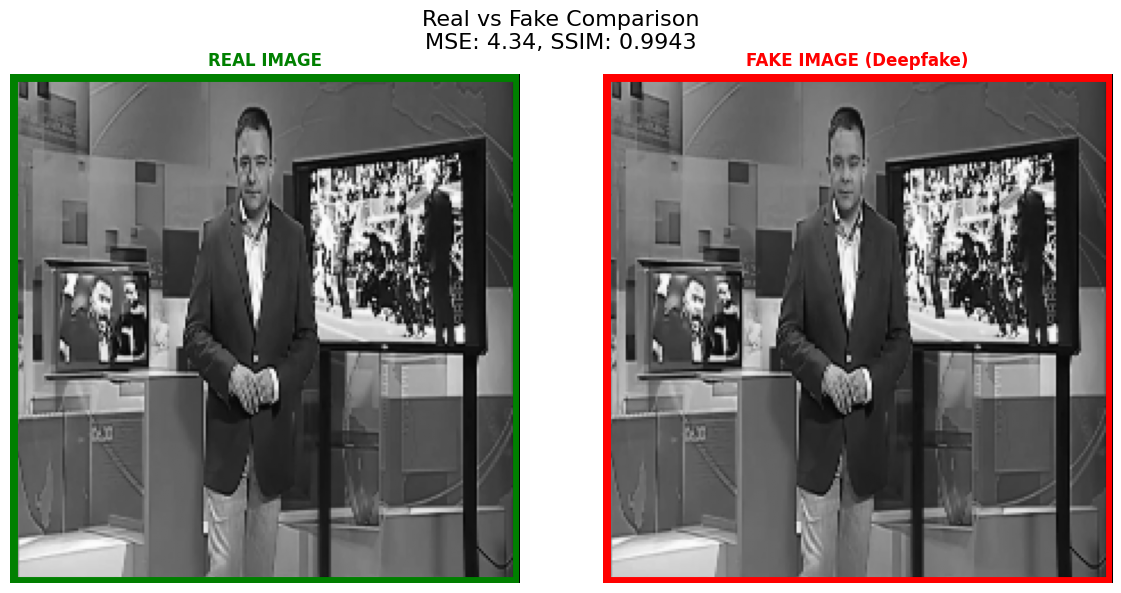

In [23]:
# 1. Load your images (provide the paths to frames you extracted earlier)
# Example: Using the 10th frame from each folder
img_real = cv2.imread(r"D:\Jupyter python\My Python\Deep Learning\deepfake data\real_frame\10.jpg")
img_fake = cv2.imread(r"D:\Jupyter python\My Python\Deep Learning\deepfake data\fake_frame\10.jpg")

# 2. Resize them to be EXACTLY the same size (Required for comparison)
img_real = cv2.resize(img_real, (224, 224))
img_fake = cv2.resize(img_fake, (224, 224))

# 3. Convert to Grayscale
gray_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2GRAY)
gray_fake = cv2.cvtColor(img_fake, cv2.COLOR_BGR2GRAY)

# 4. Call the function
compare_images(gray_real, gray_fake, "Real vs Fake Comparison")

### 1. The Script: Calculating Average Scores through all the frames we extracted.

In [24]:
def analyze_video_folders(real_folder, fake_folder):
    # Get list of files and sort them to match frames (1.jpg with 1.jpg)
    real_files = sorted(os.listdir(real_folder), key=lambda x: int(os.path.splitext(x)[0]))
    fake_files = sorted(os.listdir(fake_folder), key=lambda x: int(os.path.splitext(x)[0]))
    
    # We can only compare up to the shortest folder's length
    total_frames = min(len(real_files), len(fake_files))
    
    mse_scores = []
    ssim_scores = []

    print(f"Analyzing {total_frames} frames...")

    for i in range(total_frames):
        # Load frames
        img_real = cv2.imread(os.path.join(real_folder, real_files[i]), 0) # Load as grayscale
        img_fake = cv2.imread(os.path.join(fake_folder, fake_files[i]), 0)
        
        # Ensure identical size
        img_fake = cv2.resize(img_fake, (img_real.shape[1], img_real.shape[0]))

        # Calculate metrics
        m = np.sum((img_real.astype("float") - img_fake.astype("float")) ** 2)
        m /= float(img_real.shape[0] * img_real.shape[1])
        s = metrics.structural_similarity(img_real, img_fake)
        
        mse_scores.append(m)
        ssim_scores.append(s)

    # Calculate Averages
    avg_mse = np.mean(mse_scores)
    avg_ssim = np.mean(ssim_scores)
    
    print("-" * 30)
    print(f"AVERAGE MSE: {avg_mse:.4f}")
    print(f"AVERAGE SSIM: {avg_ssim:.4f}")
    print("-" * 30)
    
    return mse_scores, ssim_scores

# Call the analysis
mse_list, ssim_list = analyze_video_folders(real_image_path_for_frame, fake_image_path_for_frame)

Analyzing 478 frames...
------------------------------
AVERAGE MSE: 8.5987
AVERAGE SSIM: 0.9838
------------------------------


### 2. Visualization: Spotting the "Flicker"

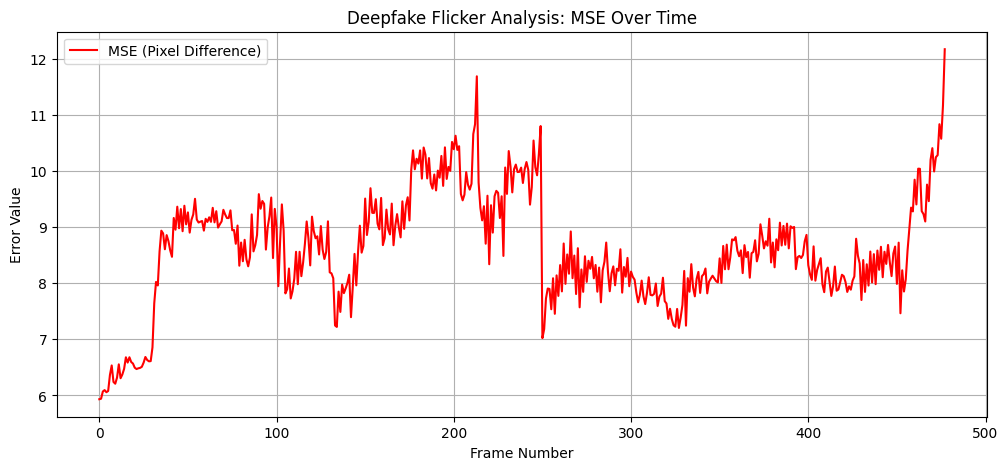

In [25]:
plt.figure(figsize=(12, 5))

# Plot MSE
plt.plot(mse_list, label='MSE (Pixel Difference)', color='red')
plt.title('Deepfake Flicker Analysis: MSE Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Error Value')
plt.legend()
plt.grid(True)

plt.show()